# Import Libraries

In [2]:
import os
import sys
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
from tqdm import tqdm
from netCDF4 import Dataset
from datetime import timedelta, date

/home/sarthakj/anaconda3/envs/multiearth/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define Paths

In [3]:
cwd = os.getcwd()
data_path = open('path_to_data.txt').read()
print(cwd, '\n', data_path)

/home/sarthakj/code/AI/projects/summers/summer_2024/AFRL 
 /home/sarthakj/data/MultiEarth/multiearth2023-dataset-final/data


# Metadata

In [4]:
# Define the path to the data directory
data_directory = data_path
DIR = sorted(os.listdir(data_directory))
#DIR = [file for file in DIR if ('deforestation' in file)]
DIR = [file for file in DIR if (('fire' not in file))]

# Initialize an empty dictionary to store the file names and their data point counts
data_counts = {}

# Loop through each file in the data directory
for filename in DIR:
    if filename.endswith('.nc'):
        # Construct the full file path
        file_path = os.path.join(data_directory, filename)
        
        # Open the .nc file
        with Dataset(file_path, 'r') as nc_file:
            # Assuming the data variable is named 'data', adjust as necessary
            data_variable = nc_file.variables['index']
            
            # Count the number of data points
            num_data_points = data_variable.size
            
            # Store the count in the dictionary
            data_counts[filename] = num_data_points

# Create a DataFrame from the dictionary
df = pd.DataFrame(list(data_counts.items()), columns=['File Name', 'Number of Data Points'])

# Display the DataFrame
print(df)

                                 File Name  Number of Data Points
0    deforestation_segmentation_targets.nc                   1000
1                   deforestation_train.nc                  17215
2                   landsat5_prediction.nc                  34965
3                        landsat5_train.nc                 429080
4   landsat8_deforestation_segmentation.nc                  10494
5                   landsat8_prediction.nc                   4483
6                        landsat8_train.nc                 233225
7      sent1_deforestation_segmentation.nc                  24131
8                      sent1_prediction.nc                   1302
9                          sent1_sar2eo.nc                   5000
10                          sent1_train.nc                 390353
11                    sent2_b1-b4_train.nc                 403163
12                    sent2_b5-b8_train.nc                 403163
13                   sent2_b9-b12_train.nc                 403163
14     sen

# NP Array Metadata

In [5]:
def np_metadata(arr, name='Array'):
    print()
    print('Name:', name)
    print('\tShape:', arr.shape)
    print('\tSize:', arr.size)
    print('\tDimensions:', arr.ndim)
    print('\tDtype:', arr.dtype)
    print('\tMemory Usage:', arr.nbytes, 'bytes')
    print('\tMIN:', arr.min())
    print('\tMAX:', arr.max())
    print('\tPreview:', arr[:10])
    print()

def np_metadata_image(image, print_unique_values=False, name='Image'):
    print()
    print('Name:', name)
    print('\tShape:', image.shape)
    print('\tSize:', image.size)
    print('\tDimensions:', image.ndim)
    print('\tDtype:', image.dtype)
    print('\tMemory Usage:', image.nbytes, 'bytes')
    print('\tMIN:', image.min())
    print('\tMAX:', image.max())
    print('\tNum Unique Values:', np.unique(image).size)
    if print_unique_values:
        print('\tUnique Values:', np.unique(image))
    '''
    print('\tPreview:')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    '''
    print()

# netCDF date interpreter

In [6]:
def days_from_date(n, date='1984-05-20'):
    date = pd.to_datetime(date)
    return (date + timedelta(days=int(n))).strftime('%Y-%m-%d')

# Look at Specific Files

### Deforestation Train

In [7]:
deforestation_train = Dataset(os.path.join(data_directory, 'deforestation_train.nc'))
print('Deforestation Train:', nc_file.variables.keys())
COORDS = np.array(deforestation_train.variables['center_lat_lons']).T
np_metadata(COORDS[0], 'Latitude')
np_metadata(COORDS[1], 'Longitude')

# Deforestation Test Set Collction Dates
dates = deforestation_train.variables['collection_dates']
dates = np.array(dates[:])
print('Collection dates:', dates, '\tLength:', len(dates))
value, counts = np.unique(dates, return_counts=True)
Gregorian_dates = [days_from_date(i, '2021-05-01') for i in value]
print('Unique Collection Dates:', Gregorian_dates)

Deforestation Train: dict_keys(['index', 'data_band', 'channel', 'row', 'col', 'images', 'collection_dates', 'geo_coord', 'center_lat_lons'])

Name: Latitude
	Shape: (17215,)
	Size: 17215
	Dimensions: 1
	Dtype: float64
	Memory Usage: 137720 bytes
	MIN: -4.39
	MAX: -3.33
	Preview: [-4.09 -3.61 -4.17 -3.39 -4.27 -3.69 -3.59 -3.91 -3.79 -3.63]


Name: Longitude
	Shape: (17215,)
	Size: 17215
	Dimensions: 1
	Dtype: float64
	Memory Usage: 137720 bytes
	MIN: -55.2
	MAX: -54.48
	Preview: [-55.06 -54.92 -54.68 -55.1  -55.12 -55.08 -54.94 -55.12 -54.58 -54.48]

Collection dates: [ 0  0  0 ... 92 92 92] 	Length: 17215
Unique Collection Dates: ['2016-08-01', '2017-07-01', '2017-08-01', '2018-06-01', '2018-08-01', '2019-07-01', '2019-08-01', '2020-06-01', '2020-08-01', '2021-05-01', '2021-08-01']


### Landsat-8 Train

In [8]:
land8_train = Dataset(os.path.join(data_directory, 'landsat8_train.nc'))
print('LANDSAT-8 Deforestation Train:', nc_file.variables.keys())
print('Image Shape:', land8_train.variables['images'].shape)
COORDS = np.array(land8_train.variables['center_lat_lons']).T
np_metadata(COORDS[0], 'Latitude')
np_metadata(COORDS[1], 'Longitude')
DATA_BANDS_1_4 = np.array(land8_train.variables['data_band'])
np_metadata(DATA_BANDS_1_4, 'Data Bands')

# Deforestation Test Set Collection Dates
dates = land8_train.variables['collection_dates']
dates = np.array(dates[:])
print('Collection dates:', dates, '\tLength:', len(dates))
value, counts = np.unique(dates, return_counts=True)
Gregorian_dates = [days_from_date(i) for i in value]
print('Unique Collection Dates:', Gregorian_dates)
np_metadata(counts, 'Unique Collection Dates Counts')

DATA_BANDS = np.array(land8_train.variables['data_band'])
DATA_BAND_DICT = {DATA_BANDS[i] : i for i in range(len(DATA_BANDS))}
print('Data Bands:', DATA_BANDS)

LANDSAT-8 Deforestation Train: dict_keys(['index', 'data_band', 'channel', 'row', 'col', 'images', 'collection_dates', 'geo_coord', 'center_lat_lons'])
Image Shape: (233225, 9, 1, 85, 85)



Name: Latitude
	Shape: (233225,)
	Size: 233225
	Dimensions: 1
	Dtype: float64
	Memory Usage: 1865800 bytes
	MIN: -4.39
	MAX: -3.33
	Preview: [-4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39 -4.39]


Name: Longitude
	Shape: (233225,)
	Size: 233225
	Dimensions: 1
	Dtype: float64
	Memory Usage: 1865800 bytes
	MIN: -55.2
	MAX: -54.48
	Preview: [-55.2 -55.2 -55.2 -55.2 -55.2 -55.2 -55.2 -55.2 -55.2 -55.2]


Name: Data Bands
	Shape: (9,)
	Size: 9
	Dimensions: 1
	Dtype: object
	Memory Usage: 72 bytes
	MIN: QA_PIXEL
	MAX: ST_B10
	Preview: ['QA_PIXEL' 'SR_B1' 'SR_B2' 'SR_B3' 'SR_B4' 'SR_B5' 'SR_B6' 'SR_B7'
 'ST_B10']

Collection dates: [   0   54   70 ... 3110 3126 3174] 	Length: 233225
Unique Collection Dates: ['1984-05-20', '1984-06-18', '1984-07-04', '1984-07-13', '1984-07-29', '1984-08-05', '1984-08-14', '1984-08-21', '1984-08-30', '1984-09-06', '1984-09-15', '1984-09-22', '1984-10-01', '1984-10-08', '1984-10-17', '1984-10-24', '1984-11-02', '1984-11-09', '1984-11-18', '1984-11-25', 

# Helper Functions

In [9]:
def detect_clouds_qa_pixel(qa_pixel_band):
    """
    Detects clouds in a QA_PIXEL band using bitmasks.
    
    Parameters:
    qa_pixel_band (numpy.ndarray): 2D NumPy array representing the QA_PIXEL band.
    
    Returns:
    numpy.ndarray: Cloud mask.
    """
    # Define the bitmask for clouds (bit 3)
    cloud_bitmask = 1 << 3
    
    # Apply the bitmask to detect clouds
    cloud_mask = (qa_pixel_band & cloud_bitmask) != 0
    
    return cloud_mask

def cv2_cloud_mask(image):
    """
    Detects clouds in a Sentinel-2 image using OpenCV.
    
    Parameters:
    image (numpy.ndarray): 3D NumPy array representing the Sentinel-2 image with bands in the order [B2, B3, B4, B8, B8A, B11, B12].
    
    Returns:
    numpy.ndarray: 2D NumPy array representing the cloud mask.
    """
    # Convert the image to 8-bit unsigned integer format
    image_8bit = (image * 255).astype(np.uint8)
    
    # Convert the image to the BGR color space
    image_bgr = cv2.cvtColor(image_8bit, cv2.COLOR_RGB2BGR)
    
    # Convert the image to the LAB color space
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab)
    
    # Split the LAB image into its components
    L, A, B = cv2.split(image_lab)
    
    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    L_clahe = clahe.apply(L)
    
    # Merge the CLAHE-enhanced L channel with the original A and B channels
    image_clahe = cv2.merge([L_clahe, A, B])
    
    # Convert the image back to the RGB color space
    image_rgb_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_Lab2RGB)
    
    # Convert the image to the HSV color space
    image_hsv = cv2.cvtColor(image_rgb_clahe, cv2.COLOR_RGB2HSV)
    
    # Threshold the image to get a binary mask of clouds
    lower = np.array([0, 0, 0])
    upper = np.array([180, 40, 255])
    cloud_mask = cv2.inRange(image_hsv, lower, upper)
    
    return cloud_mask

# Get Sample RGB images + Cloud Masks

LANDSAT-8 Deforestation Train: dict_keys(['index', 'data_band', 'channel', 'row', 'col', 'images', 'collection_dates', 'geo_coord', 'center_lat_lons'])
Random Indicies: [226373, 25695, 106249, 134452, 93142, 119562, 121907, 62248, 217941, 31665, 68107, 138755, 129110, 44976, 173136, 109241, 47708, 144101, 133236, 18349]
RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 9372



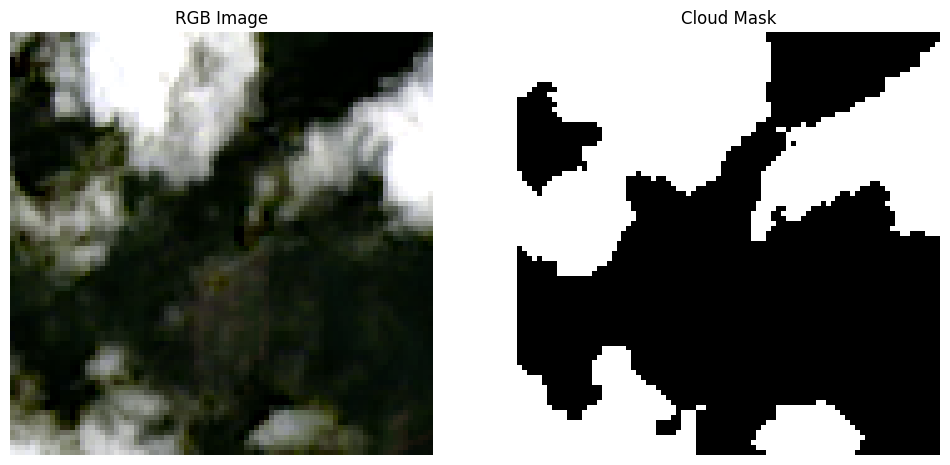

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 9091



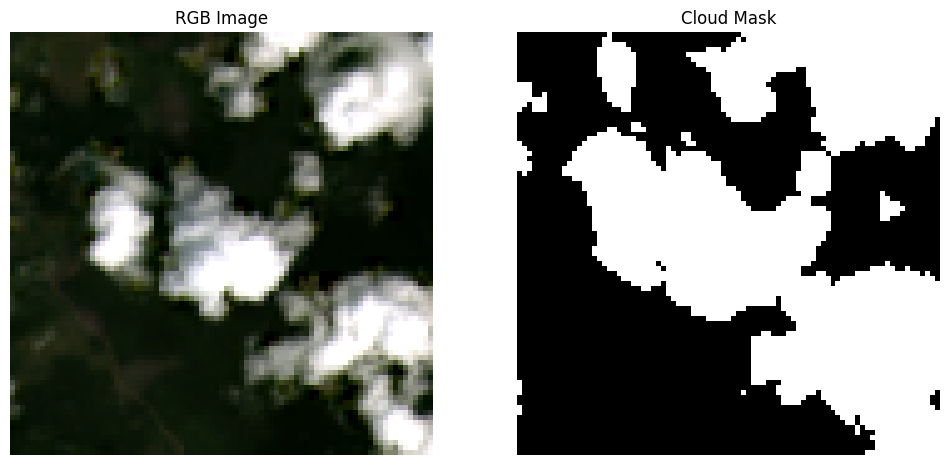

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 4783



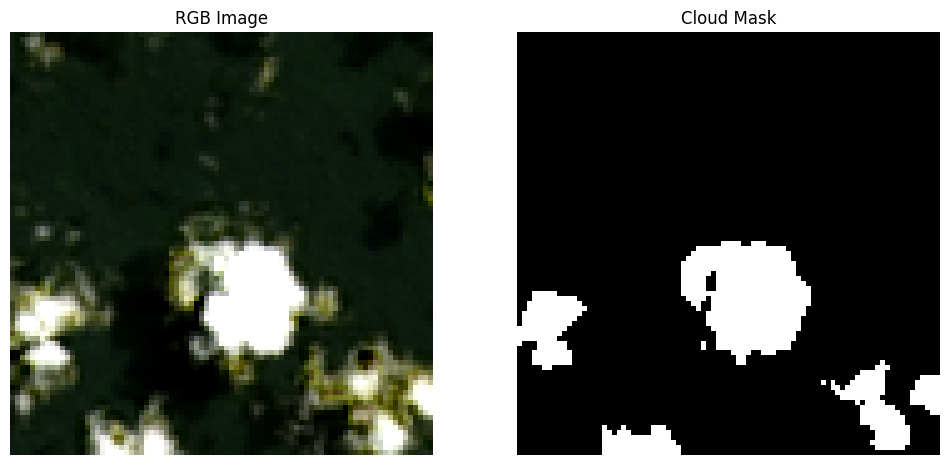

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 11821



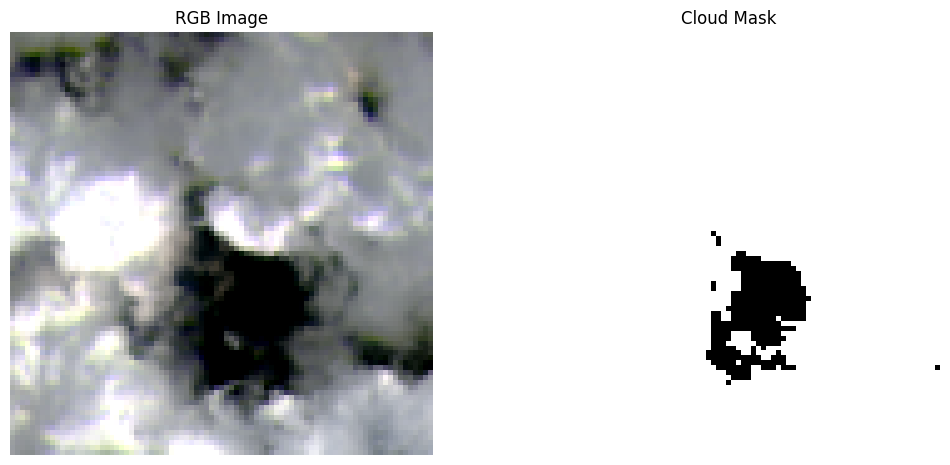

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 11535



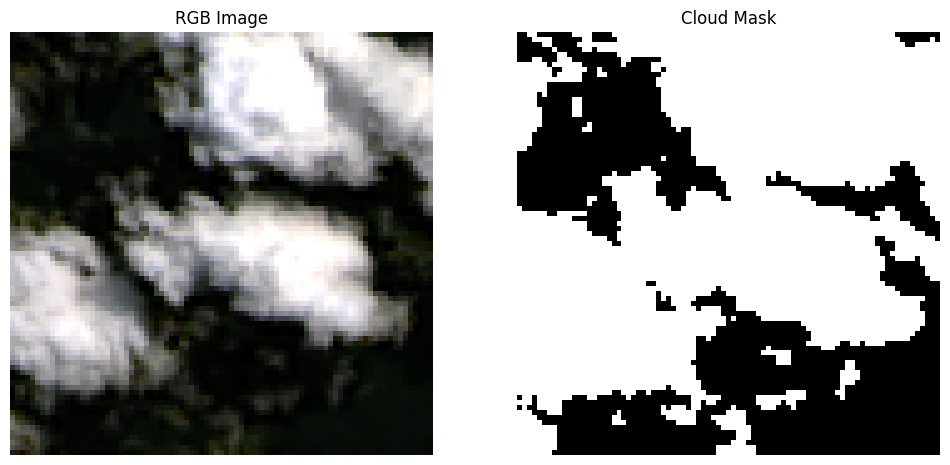

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 3452



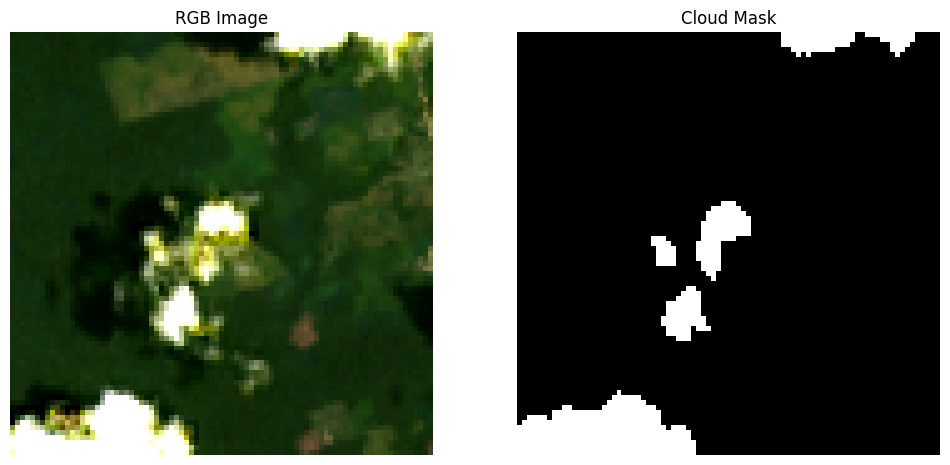

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 4915



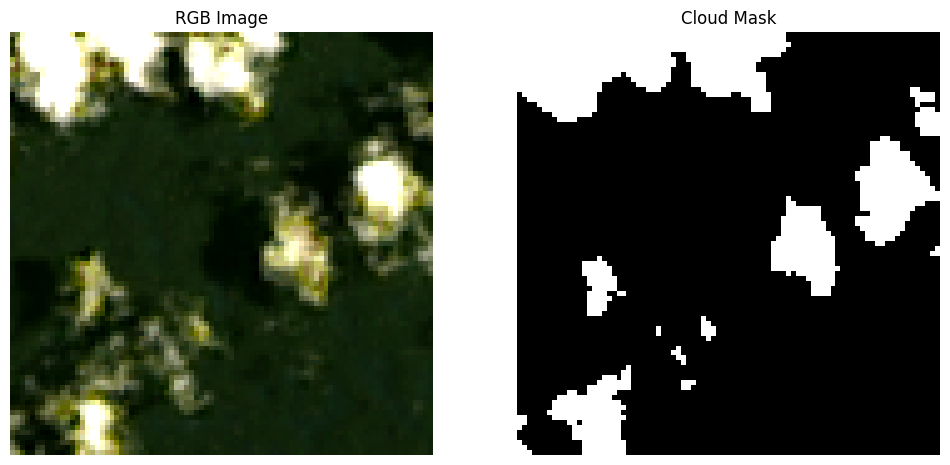

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 3587



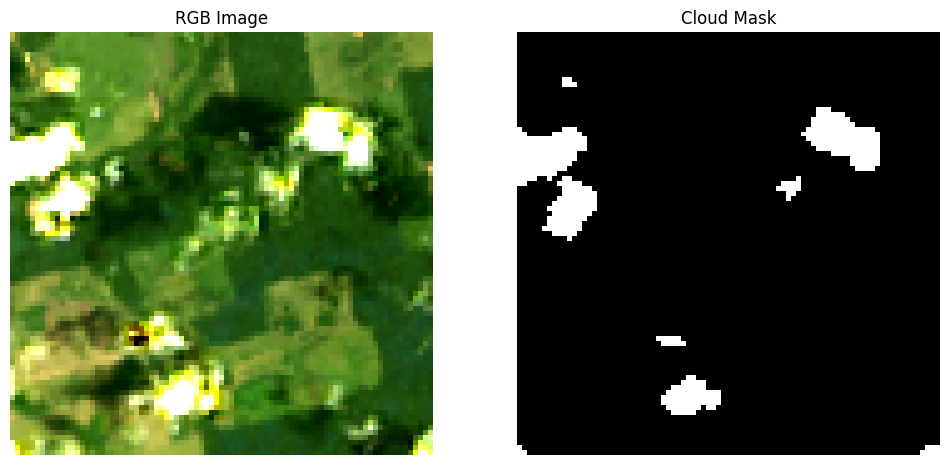

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 11755



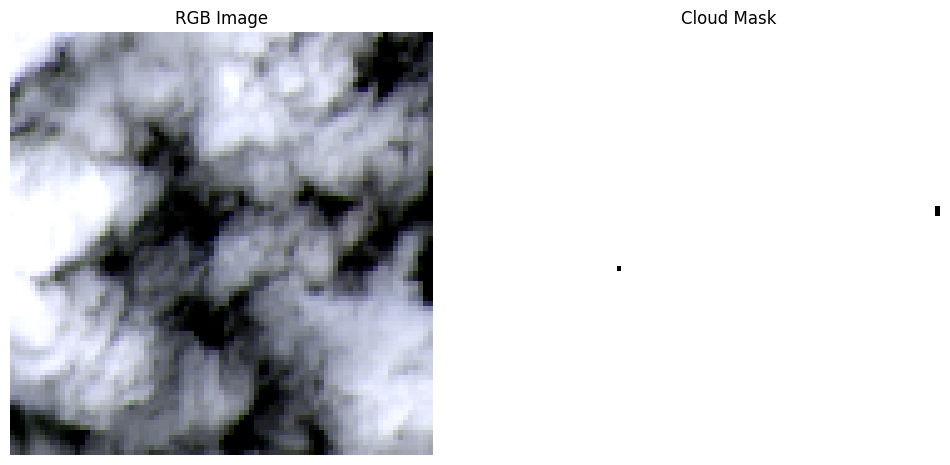

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 7527



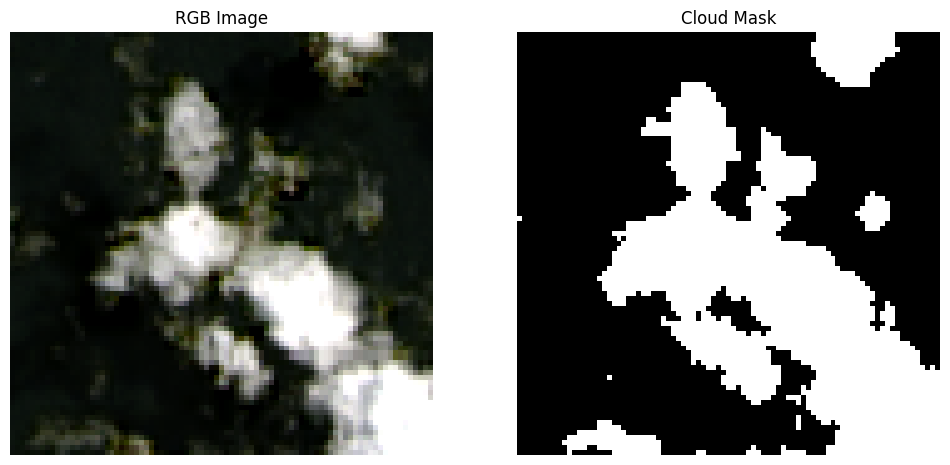

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 6202



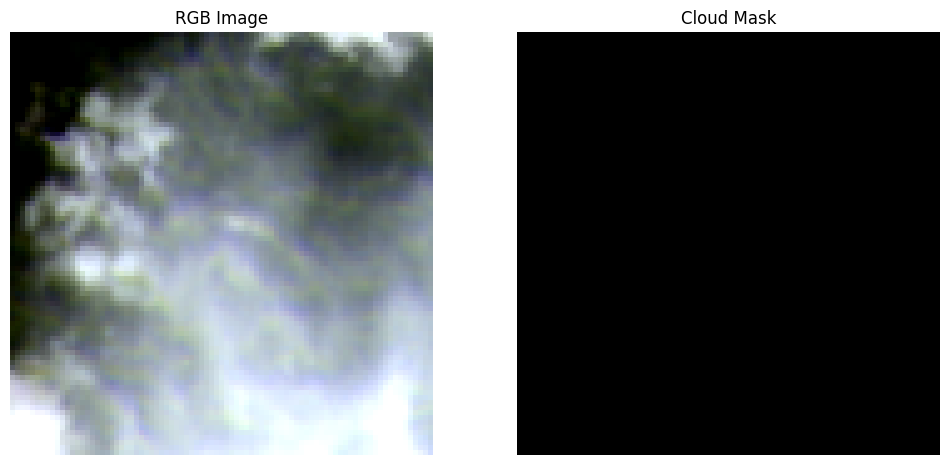

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 7534



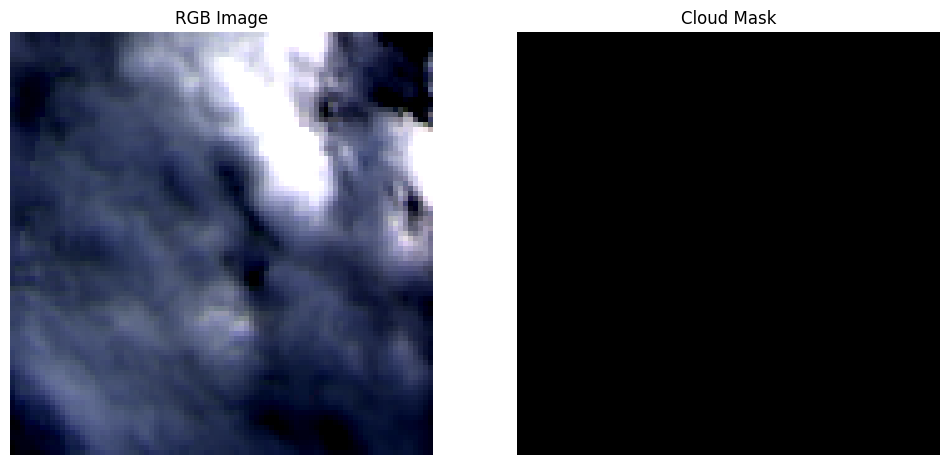

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 1505



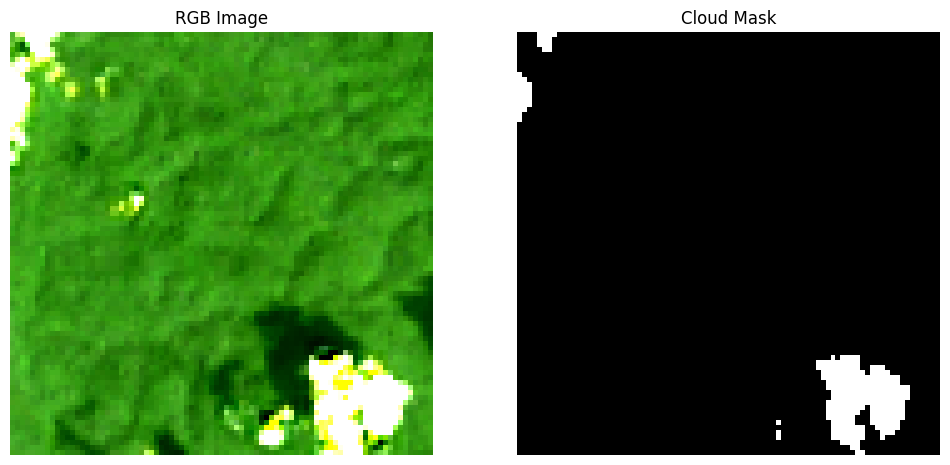

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 9480



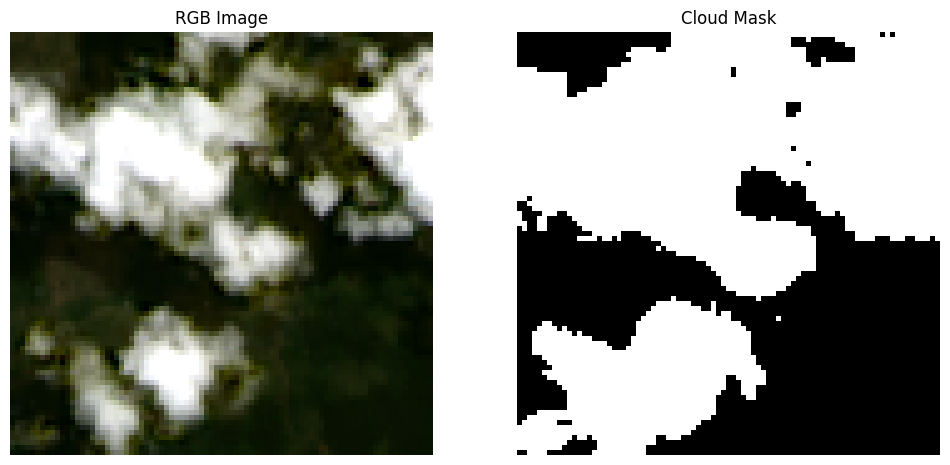

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 10245



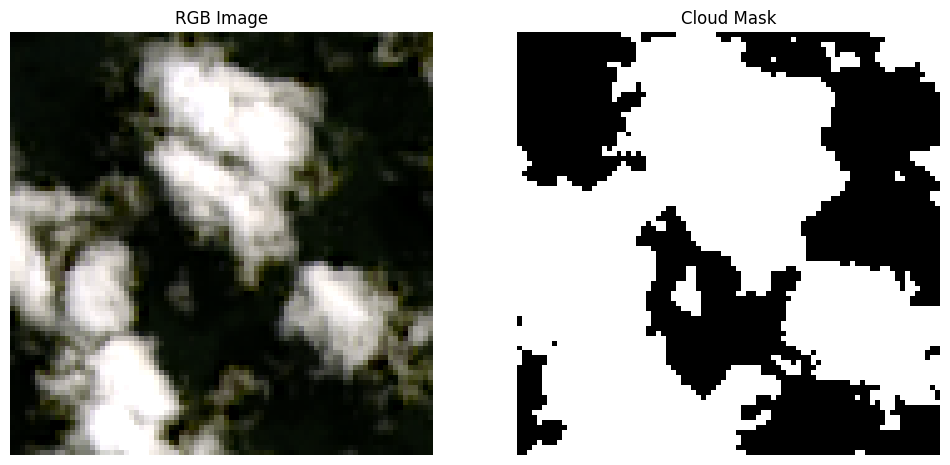

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 11896



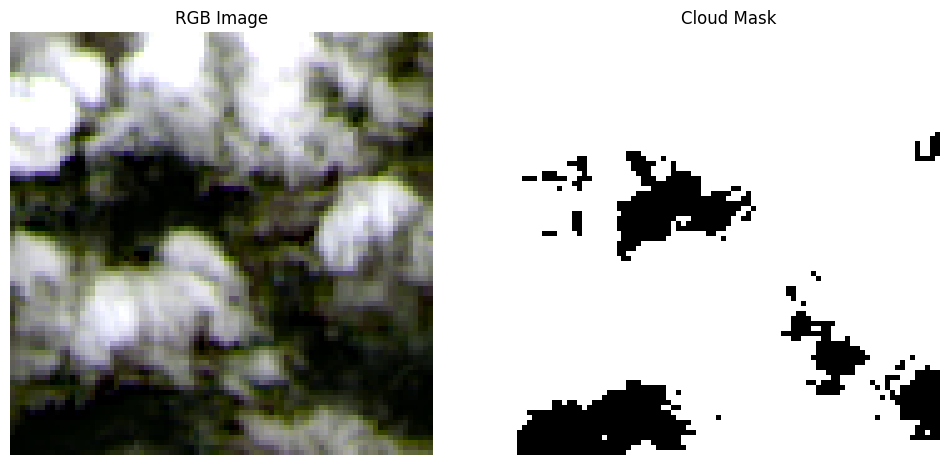

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 2119



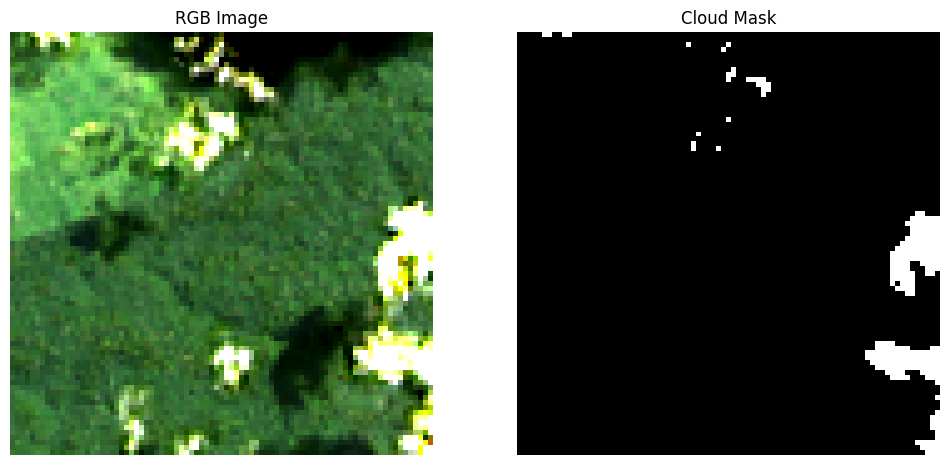

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 2825



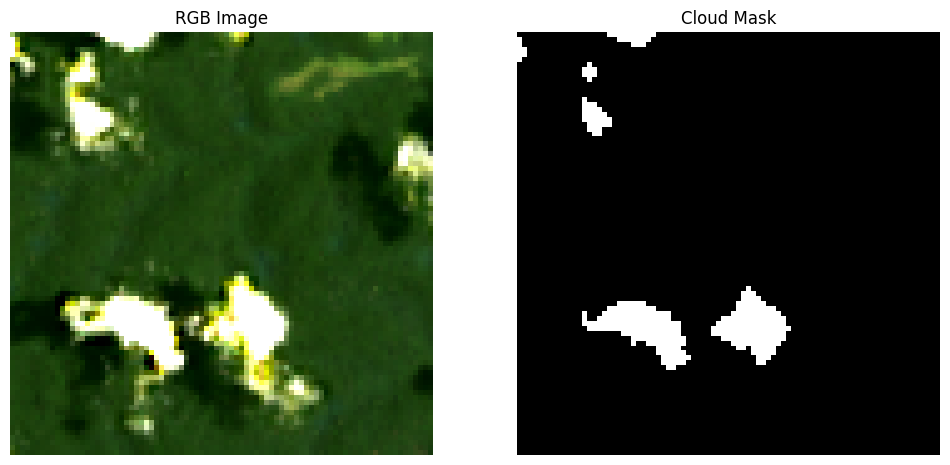

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 7249



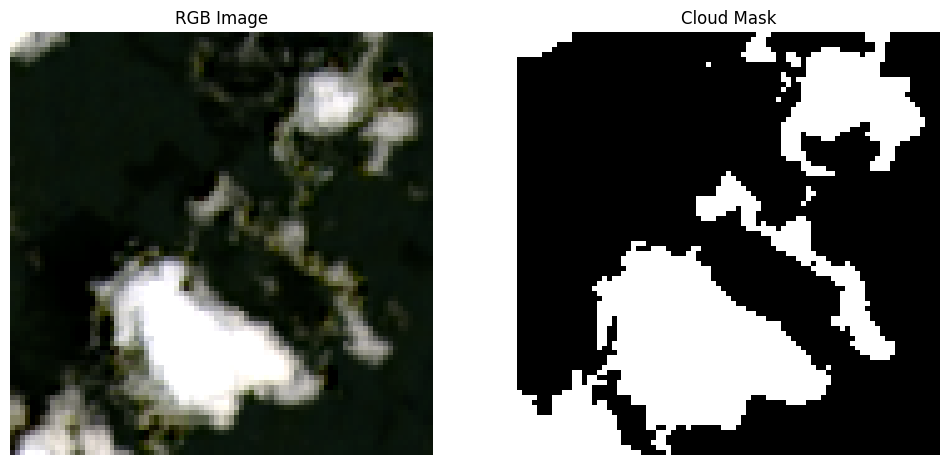

RGB Bands: [4, 3, 2]

Name: Image
	Shape: (3, 85, 85)
	Size: 21675
	Dimensions: 3
	Dtype: float32
	Memory Usage: 86700 bytes
	MIN: 0.0
	MAX: 1.0
	Num Unique Values: 13408



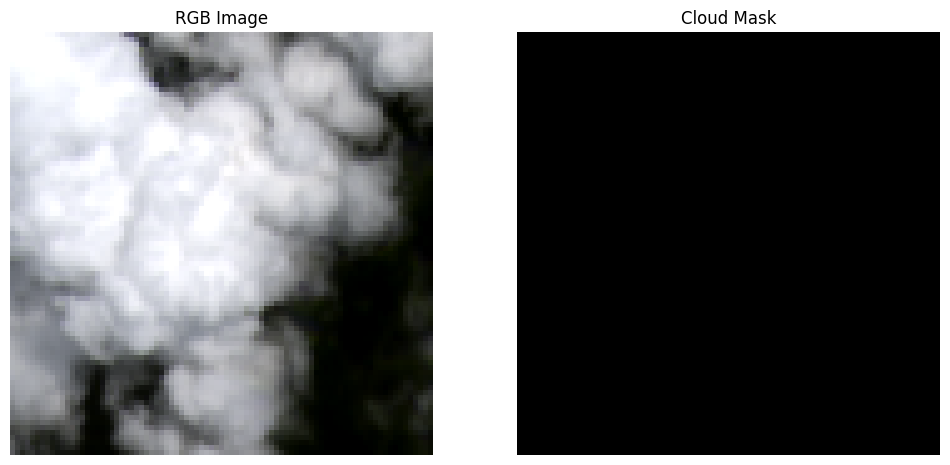

In [12]:
land5_train = Dataset(os.path.join(data_directory, 'landsat8_train.nc'))
print('LANDSAT-8 Deforestation Train:', nc_file.variables.keys())

indicies = list(range(land5_train.variables['images'].shape[0]))
indicies = random.sample(indicies, 20)
print('Random Indicies:', indicies)

def show_image(index): 
    image = np.array(land5_train.variables['images'][index]).squeeze()

    RGB_BANDS = [DATA_BAND_DICT['SR_B4'], DATA_BAND_DICT['SR_B3'], DATA_BAND_DICT['SR_B2']]
    print('RGB Bands:', RGB_BANDS)
    RGB_IMAGE = image[RGB_BANDS].astype(np.float32)
    percentiles = np.percentile(RGB_IMAGE, (5, 95))
    RGB_IMAGE = np.clip(RGB_IMAGE, percentiles[0], percentiles[1]) - percentiles[0]
    RGB_IMAGE = RGB_IMAGE / np.max(RGB_IMAGE)
    np_metadata_image(RGB_IMAGE, name='Image')
    RGB_IMAGE = RGB_IMAGE.transpose((1, 2, 0))

    QA_PIXEL = image[DATA_BAND_DICT['QA_PIXEL']]
    cloud_mask = detect_clouds_qa_pixel(QA_PIXEL)

    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(RGB_IMAGE)
    plt.title('RGB Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cloud_mask, cmap='gray')
    plt.title('Cloud Mask')
    plt.axis('off')
    plt.show()

for I in indicies:
    show_image(I)


# Get Cloud Coverage

In [ ]:
sent2_meta = []

def cloud_coverage(i):
    image = np.array(sent2_b1_b4_train.variables['images'][i][1:4])[::-1].squeeze().transpose(1, 2, 0)

    # clip bottom and top 5% of pixel values to remove outliers and normalize
    percentile = np.percentile(image, [5, 95])
    image = np.clip(image, percentile[0], percentile[1])
    image = (image - percentile[0]) / (percentile[1] - percentile[0])

    cloud_mask_cv2 = cv2_cloud_mask(image)/255
    cv2_cloud_percentage = np.sum(cloud_mask_cv2) / cloud_mask_cv2.size * 100

    # find average pixel values excluding clouds
    tmp = np.mean(image, axis=-1)
    tmp = tmp - cloud_mask_cv2
    tmp[tmp < 0] = 0
    rgb_mean = tmp.sum() / np.sum(cloud_mask_cv2 == 0)
    

    mask = np.array(sent2_b1_b4_train.variables['images'][i])[4]
    return (detect_clouds_qa60(mask), rgb_mean, cv2_cloud_percentage)

num_processes = mp.cpu_count()
print('Number of processes:', num_processes)
pool = mp.Pool(processes=num_processes)
args = [(i) for i in range(sent2_b1_b4_train.variables['index'].size)]

for cloud in tqdm(pool.imap(cloud_coverage, args), total=len(args)):
    sent2_meta.append(cloud)

pool.close()
pool.join()

sent2_meta = np.array(sent2_meta)
np_metadata(sent2_meta, 'Cloud Coverage')
# save the cloud coverage list
np.save('sent2_metadata.npy', sent2_meta)

# Cloud Coverage Analysis

In [ ]:
# Load the cloud coverage list
sent2_meta = np.load('cloud_coverage_list.npy').T
cloud_coverage_list, rgb_mean, cv2_cloud_coverage_list = sent2_meta
np_metadata(cloud_coverage_list, 'Cloud Coverage')

# Plot the cloud coverage distribution
plt.figure(figsize=(10, 6))
sns.histplot(cloud_coverage_list, bins=20, kde=True, color='blue')
plt.title('Cloud Coverage Distribution')
plt.xlabel('Cloud Coverage (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Plot the rgb mean distribution
plt.figure(figsize=(10, 6))
sns.histplot(rgb_mean, bins=20, kde=True, color='blue')
plt.title('RGB Mean Distribution')
plt.xlabel('RGB Mean')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Plot the cv2 cloud coverage distribution
plt.figure(figsize=(10, 6))
sns.histplot(cv2_cloud_coverage_list, bins=20, kde=True, color='blue')
plt.title('CV2 Cloud Coverage Distribution')
plt.xlabel('Cloud Coverage (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


TABLE = [[] for i in range(11)]

for cloud_tolerance in range(0, 101, 10):
    for rgb_tolerance in range(0, 11, 1):
        cnt = 0
        for i in range(len(cloud_coverage_list)):
            if cv2_cloud_coverage_list[i] <= cloud_tolerance and rgb_mean[i] >= rgb_tolerance * 0.1 and cloud_coverage_list[i] <= 40:
                cnt += 1
        TABLE[cloud_tolerance // 10].append(cnt)

TABLE = np.array(TABLE)
# plot the table
plt.figure(figsize=(10, 6))
sns.heatmap(TABLE, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('CV2 Cloud Coverage vs RGB Mean')
plt.xlabel('RGB Tolerance (%)')
plt.ylabel('CN2 Cloud Tolerance (%)')
plt.xticks(ticks=np.arange(11), labels=[str(i*0.1) for i in range(0, 11, 1)])
plt.yticks(ticks=np.arange(11), labels=[str(i) for i in range(0, 101, 10)])
plt.show()
        

# Save some valid data

In [ ]:
def save_image(index):
    # Load the image & normalize
    image = np.array(sent2_b1_b4_train.variables['images'][index]).squeeze()[1:4][::-1].transpose(1, 2, 0)
    percentage = np.percentile(image, [5, 95])
    image = np.clip(image, percentage[0], percentage[1])
    image = (image - percentage[0]) / (percentage[1] - percentage[0])

    # Load the QA60 band cloud mask
    qa60 = np.array(sent2_b1_b4_train.variables['images'][index]).squeeze()[4]
    qa60 = np.stack(3*[qa60/2048.], axis=-1)

    # Create cv2 cloud mask
    cloud_mask = cv2_cloud_mask(image)
    cv2_cloud_percentage = np.sum(cloud_mask/256) / cloud_mask.size * 100

    # Create fig for plotting image and QA60 and cv2 cloud mask
    fig = plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('RGB Image')
    plt.subplot(1, 3, 2)
    plt.imshow((qa60), cmap='gray')
    plt.axis('off')
    plt.title('QA60 Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(cloud_mask, cmap='gray')
    plt.axis('off')
    plt.title('CV2 Mask')
    plt.close(fig)
    fig.savefig(f'pngs/filtered_sentinel2_pngs/{index}_{sent2_meta[0][index]:.2f}_{sent2_meta[1][index]:.3f}_{cv2_cloud_percentage:.3f}.png')

num_processes = mp.cpu_count()
print('Number of processes:', mp)
pool = mp.Pool(processes=num_processes)
args = [(i) for i in range(len(sent2_meta[0])) if (sent2_meta[0][i] <= 40 and sent2_meta[1][i] >= 0.1 and sent2_meta[2][i] <= 10)]
print('Number of images:', len(args))
args = random.sample(args, 500)
for _ in tqdm(pool.imap(save_image, args), total=len(args)):
    pass
pool.close()
pool.join()

# Save some invalid data

In [ ]:
def save_image(index):
    # Load the image & normalize
    image = np.array(sent2_b1_b4_train.variables['images'][index]).squeeze()[1:4][::-1].transpose(1, 2, 0)
    percentage = np.percentile(image, [5, 95])
    image = np.clip(image, percentage[0], percentage[1])
    image = (image - percentage[0]) / (percentage[1] - percentage[0])

    # Load the QA60 band cloud mask
    qa60 = np.array(sent2_b1_b4_train.variables['images'][index]).squeeze()[4]
    qa60 = np.stack(3*[qa60/2048.], axis=-1)

    # Create cv2 cloud mask
    cloud_mask = cv2_cloud_mask(image)
    cv2_cloud_percentage = np.sum(cloud_mask/255) / cloud_mask.size * 100

    # Create fig for plotting image and QA60 and cv2 cloud mask
    fig = plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('RGB Image')
    plt.subplot(1, 3, 2)
    plt.imshow((qa60), cmap='gray')
    plt.axis('off')
    plt.title('QA60 Mask')
    plt.subplot(1, 3, 3)
    plt.imshow(cloud_mask, cmap='gray')
    plt.axis('off')
    plt.title('CV2 Mask')
    plt.close(fig)
    fig.savefig(f'pngs/filtered_sentinel2_invalid_pngs/{index}_{sent2_meta[0][index]:.2f}_{sent2_meta[1][index]:.3f}_{cv2_cloud_percentage:.3f}.png')

num_processes = mp.cpu_count()
print('Number of processes:', mp)
pool = mp.Pool(processes=num_processes)
args = [i for i in range(len(sent2_meta[0])) if (sent2_meta[0][i] <= 40 and sent2_meta[1][i] >= 0.1 and sent2_meta[2][i] <= 10)]
tmp_dict = {i: None for i in args}
args = [(i) for i in range(len(sent2_meta[0])) if i not in tmp_dict]
print('Number of images:', len(args))
args = random.sample(args, 500)
for _ in tqdm(pool.imap(save_image, args), total=len(args)):
    pass
pool.close()
pool.join()